In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pandas as pd
import numpy as np

from kernel_wasserstein_flows.gradient_flow import gradient_flow
from kernel_wasserstein_flows.utils import generate_XY_mog_square
from kernel_wasserstein_flows.kernels import gaussian_kernel
from kernel_wasserstein_flows.config import LOG_LEVELS
import kernel_wasserstein_flows.gradient_flow as gf

gf.MAX_TRAJECTORY_SNAPSHOTS = 1000
LOG_LEVELS['gradient_flow'] = logging.INFO
# LOG_LEVELS['kale.gradient_descent'] = logging.INFO
# LOG_LEVELS['kale.optim.newton'] = logging.INFO

# Run Gradient Flows

In [1]:
results = {}

In [2]:
import logging
import pandas as pd
import numpy as np

from kernel_wasserstein_flows.gradient_flow import gradient_flow
from kernel_wasserstein_flows.utils import generate_XY_mog_square
from kernel_wasserstein_flows.kernels import gaussian_kernel
from kernel_wasserstein_flows.config import LOG_LEVELS
import kernel_wasserstein_flows.gradient_flow as gf

gf.MAX_TRAJECTORY_SNAPSHOTS = 1000
LOG_LEVELS['gradient_flow'] = logging.INFO
# LOG_LEVELS['kale.gradient_descent'] = logging.INFO
# LOG_LEVELS['kale.optim.newton'] = logging.INFO"

In [3]:
_gf_default_kwargs = dict(
    max_iter=50000,
    lr=0.001,
    random_seed=20,
    num_noisy_averages=1,
    generator=generate_XY_mog_square,
    generator_kwargs=dict(N=240, d=2, dist=1.8, std=1/4, random_seed=42, y_std=0.2, y_rel_dist=0.1, return_potential_functions=False),
    kernel=gaussian_kernel,
    kernel_kwargs={'sigma': 0.5},
)

_kale_default_kwargs={
    "inner_max_iter": 200,
    "inner_tol": 1e-6,
    "inner_a": 0.4,
    "inner_b": 0.8,
    "inplace": False,
    "input_check":True,
    "dual_gap_tol": 1e-3
}

In [4]:
from kernel_wasserstein_flows.mmd import mmd, mmd_first_variation
from kernel_wasserstein_flows.kale import kale_penalized, kale_penalized_first_variation
# from kernel_wasserstein_flows.kale_torch import kale_penalized, kale_penalized_first_variation

cases = [
    ("mmd", mmd, mmd_first_variation, {}, lambda x:1e-10),
    ("kale_10000", kale_penalized, kale_penalized_first_variation, {'lambda_': 10000, **_kale_default_kwargs}, lambda x:1e-10),
    ("kale_01", kale_penalized, kale_penalized_first_variation, {'lambda_': 0.1, **_kale_default_kwargs}, lambda x:1e-10),
    ("kale_01_noise_injection", kale_penalized, kale_penalized_first_variation, {'lambda_': 0.1, **_kale_default_kwargs}, lambda x:3e-1),
    ("kale_0001", kale_penalized, kale_penalized_first_variation, {'lambda_': 0.001, **_kale_default_kwargs}, lambda x:1e-10)
]

In [5]:
results = {}
for name, loss, loss_first_var, loss_kwargs, noise_injection_callback in cases:
    args, (X, Y), (trajectories, records, loss_states) = gradient_flow(
        loss=loss, loss_first_variation=loss_first_var, loss_kwargs=loss_kwargs, noise_level_callback=noise_injection_callback, **_gf_default_kwargs
    )
    results[name] = {'args': args, 'X': X, 'Y': Y, 'trajectories': trajectories, 'records': records, 'loss_states': loss_states}

 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: loss: 2.78e-01 grad_norm: 8.48e+00
 gradient_flow: loss: 6.00e-02 grad_norm: 1.48e+00
 gradient_flow: loss: 3.79e-02 grad_norm: 7.54e-01
 gradient_flow: loss: 2.90e-02 grad_norm: 4.62e-01
 gradient_flow: loss: 2.58e-02 grad_norm: 3.86e-01
 gradient_flow: loss: 2.22e-02 grad_norm: 3.61e-01
 gradient_flow: loss: 2.03e-02 grad_norm: 2.83e-01
 gradient_flow: loss: 1.89e-02 grad_norm: 2.81e-01
 gradient_flow: loss: 1.72e-02 grad_norm: 3.07e-01
 gradient_flow: loss: 1.48e-02 grad_norm: 3.48e-01
 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: loss: 2.78e-01 grad_norm: 8.48e+00
 gradient_flow: loss: 6.00e-02 grad_norm: 1.48e+00
 gradient_flow: loss: 3.79e-02 grad_norm: 7.54e-01
 gradient_flow: loss: 2.90e-02 grad_norm: 4.62e-01
 gradient_flow: loss: 2.58e-02 grad_norm: 3.86e-01
 gradient_flow: loss: 2.22e-02 grad_norm: 3.60e-01
 gradient_flow: loss: 2.03e-02 grad_norm: 2.83e-01
 gradient

In [6]:
# uncomment lines below in this cell to view an interactive visualisation of the computed flows
# from kernel_wasserstein_flows.plotting  import vizualize_results
# from kernel_wasserstein_flows.utils  import compute_velocity_field
# 
# %matplotlib ipympl
# 
# _exp_name = "kale_01"
# 
# args, X, Y, trajectories, records, loss_states =  results[_exp_name]['args'], results[_exp_name]['X'], results[_exp_name]['Y'], results[_exp_name]['trajectories'], results[_exp_name]['records'], results[_exp_name]['loss_states']
# 
# if args['generator_kwargs'].get('d') == 2:
#     vs = compute_velocity_field(
#         X, trajectories,
#         args['kernel'], args['kernel_kwargs'], args['loss'], args['loss_kwargs'],
#         args['loss_first_variation'], loss_states
#     )
# else:
#     vs = None
# vizualize_results(X, Y, trajectories, pd.json_normalize(records), _exp_name, metrics_subset=['loss'],
#                   velocities=vs)

In [8]:
from kernel_wasserstein_flows.extras import unadjusted_langevin_algorithm

args, (X, Y), (trajectories, records, loss_states) = unadjusted_langevin_algorithm(
    max_iter=50000,
    lr=0.001,
    random_seed=42,
    generator=generate_XY_mog_square,
    generator_kwargs=dict(N=240, d=2, dist=1.8, std=1/4, random_seed=42, y_std=0.2, y_rel_dist=0.1, return_potential_functions=True),
)
results['kl'] = {'args': args, 'X': X, 'Y': Y, 'trajectories': trajectories[::50], 'records': records, 'loss_states': loss_states}

In [9]:
# vizualize_results(X, Y, trajectories, None, None, metrics_subset=[],velocities=None)

# Compare Gradient Flows Trajectories via Sinkhorn Divergence

In [10]:
import ot
import numpy as np
all_sinkhorn_distances = {}

couples_kl = (('kl', 'mmd'), ('kl', 'kale_0001'), ('kl', 'kale_01'), ('kl', 'kale_10000'))
couples_mmd = (('mmd', 'kl'), ('mmd', 'kale_0001'), ('mmd', 'kale_01'), ('mmd', 'kale_10000'))

i = 0
for reference_div, couples in zip(('kl', 'mmd'), (couples_kl, couples_mmd)):
    sinkhorn_distances_reference_div = {}
    for couple in couples:
        print(couple)
        sinkhorn_dists = []
        div1, div2 = couple
        for (_Y1, _Y2) in zip(
            results[div1]['trajectories'][::10],
            results[div2]['trajectories'][::10]
        ):
            _X1 = results[div1]['X']
            _X2 = results[div2]['X']

            _M =  ((_Y1[:, None, :] - _Y2[None, :, :])**2).sum(axis=2)
            ret =ot.sinkhorn(
                1/len(_Y1) * np.ones((len(_Y1),)), 1/len(_Y2) * np.ones((len(_Y2),)), _M, reg=0.2
            )
            sinkhorn_dists.append((ret * _M).sum())
        sinkhorn_distances_reference_div[couple] = sinkhorn_dists
    all_sinkhorn_distances[reference_div] = sinkhorn_distances_reference_div


('kl', 'mmd')
('kl', 'kale_0001')


/Users/pierreglaser/.local/miniforge/envs/kale-flow/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


('kl', 'kale_01')
('kl', 'kale_10000')
('mmd', 'kl')
('mmd', 'kale_0001')
('mmd', 'kale_01')
('mmd', 'kale_10000')


Text(0.5, 1.0, 'KALE')

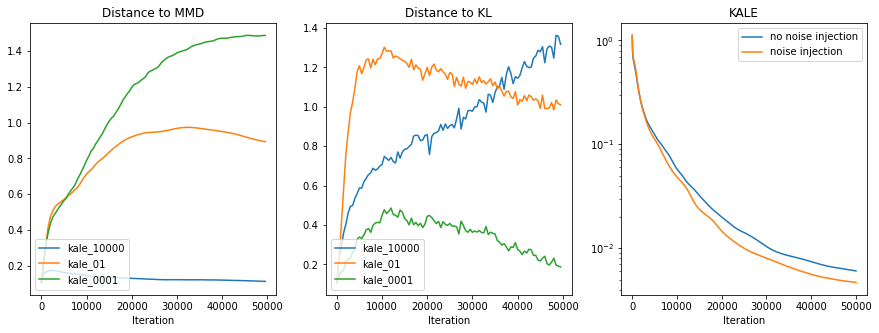

In [22]:
import matplotlib.pyplot as plt
from matplotlib import rc

f, axs = plt.subplots(ncols=3, figsize=(15, 5))

for ax, _ref_div_name in zip(axs, ('mmd', 'kl')):
    for exp_name in results.keys():
        if exp_name in ('kl', 'mmd', 'kale_01_noise_injection'):
            continue
        iterations = [i * 500 for i in range(len(all_sinkhorn_distances[_ref_div_name][(_ref_div_name,exp_name)]))]
        ax.plot(iterations, all_sinkhorn_distances[_ref_div_name][(_ref_div_name,exp_name)], label=exp_name)
    ax.legend(loc='lower left')
    ax.set_xlabel('Iteration')
    ax.set_title(f'Distance to {_ref_div_name.upper()}')
    
axs[-1].plot([r['loss'] for r in results['kale_01']['records']], label='no noise injection')
axs[-1].plot([r['loss'] for r in results['kale_01_noise_injection']['records']], label='noise injection')
axs[-1].set_yscale('log')
axs[-1].set_xlabel('Iteration')
axs[-1].legend()
axs[-1].set_title('KALE')